In [1]:
import warnings
import torch
import numpy as np

from idt.data import data
from idt.ui import DBG, HLT, NEW, NXT, END, MRK, HLN, CND, ERR, PLT

# suppressing some irrelevant warnings
warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
import logging
logging.getLogger('lightning').setLevel(0)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)

data_name = 'EMLC1'
seed      = 42 
rng       = np.random.default_rng(seed)

num_features, num_classes, train_loader, val_loader, train_val_batch, test_batch = data(data_name, 5, 0, rng)
    
bincount = torch.bincount(train_val_batch.y, minlength=2)
weight = len(train_val_batch) / (2 * bincount.float())


[+] generating dataset

[*] dataset type = EMLC1

[*] samples = 500

[*] folds = 5


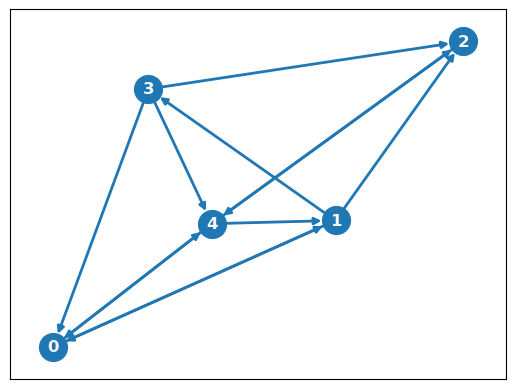

A:
[[0 1 0 0 1]
 [1 0 1 1 0]
 [0 0 0 0 1]
 [1 0 1 0 1]
 [1 1 1 0 0]]

A^T:
[[0 1 0 1 1]
 [1 0 0 0 1]
 [0 1 0 1 1]
 [0 1 0 0 0]
 [1 0 1 1 0]]

U_0:
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]]

U_1:
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]



Data(x=[5, 1], edge_index=[2, 12], y=0)

In [2]:
from idt.data import _generate_EMLC_sample
_generate_EMLC_sample(data_name, rng, directed=True)

In [3]:
from lightning import Trainer
from lightning.pytorch.callbacks.early_stopping import EarlyStopping

from idt.gnn import GNN

torch.set_float32_matmul_precision('high')

GCN = GNN(num_features, num_classes, layers=8, dim=128, activation="ReLU", conv="GCN", pool="mean", lr=1e-4, weight=weight)
early_stop_callback = EarlyStopping(monitor="GCN_val_loss", patience=10, mode="min")

trainer = Trainer(
    max_steps=1000,
    enable_checkpointing=False,
    enable_progress_bar=False,
    log_every_n_steps=1,
    callbacks=[early_stop_callback],
)

NEW("STARTING :: gnn.py -> class GNN -> fit()")
print("")
trainer.fit(GCN, train_dataloaders=train_loader, val_dataloaders=val_loader)
#END("COMPLETED :: gnn.py -> class GNN -> __init__()")


[+] STARTING :: gnn.py -> class GNN -> __init__()

[*] convolution layers =  8 x GCNConv(128, 128)

[*] activation = ReLU

[+] STARTING :: gnn.py -> class GNN -> fit()




  | Name        | Type       | Params
-------------------------------------------
0 | embedding   | Linear     | 256   
1 | act         | ReLU       | 0     
2 | norms       | ModuleList | 3.1 K 
3 | conv_layers | ModuleList | 132 K 
4 | out         | Sequential | 16.8 K
5 | loss        | NLLLoss    | 0     
-------------------------------------------
152 K     Trainable params
0         Non-trainable params
152 K     Total params
0.609     Total estimated model params size (MB)


In [4]:
from idt.idt import IDT, get_activations

idt = IDT(width=4, sample_size=1000, layer_depth=2, max_depth=None, ccp_alpha=1e-3)
values = get_activations(train_val_batch, GCN)
#print(type(train_val_batch))
idt.fit(train_val_batch, values, train_val_batch.y)
print(f"""
    GCN test accuracy: {(GCN(test_batch).argmax(-1) == test_batch.y).float().mean().item()}
    IDT test accuracy: {idt.accuracy(test_batch)}
    IDT F1 score:      {idt.f1_score(test_batch)}
    Fidelity:          {idt.fidelity(test_batch, GCN)}""")


[+] STARTING :: idt.py -> class IDT -> fit()

[*] 32 layers computed

[*] out_layer computed

    GCN test accuracy: 0.800000011920929
    IDT test accuracy: 1.0
    IDT F1 score:      1.0
    Fidelity:          0.8



[+] STARTING :: idt.py -> class IDT -> prune()

[✓] COMPLETED :: idt.py -> class IDT -> prune()


[+] STARTING :: idt.py -> class IDT -> plot()

[+] plotting layer 0

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 1

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 2
The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node with value=128: go to node 1 if X[:, 1] <= 3.747733196126173 else to node 4.
	node=1 is a leaf node with value=128.
	node=4 is a leaf node with value=128.

[✓] successfully plotted layer 2


[+] plotting layer 3

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 4

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 5

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 6

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 7

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 8

[*] layer pruned

[✓] nothing to plot


[+] plotting layer 9

[*] layer pruned

[✓] no

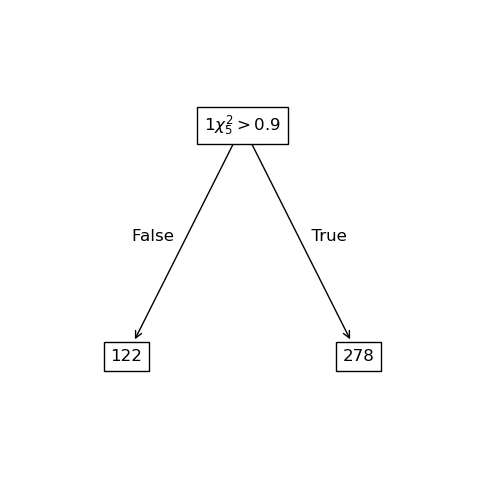

In [5]:
tree = idt.prune()
idt.plot()

In [17]:
import copy
idt_test = copy.deepcopy(idt)

def _feature_formula(index, depth_indices):
    from idt.ui import DBG, HLT, NEW, NXT, END, MRK, HLN, CND, ERR, PLT
    depth, index = _feature_depth_index(index, depth_indices)
    if depth == -1:
        return fr'U_{{{index}}}'
    else:
        return fr'\chi_{{{index}}}^{{{depth}}}'

def _feature_depth_index(index, depth_indices):
    from idt.ui import DBG, HLT, NEW, NXT, END, MRK, HLN, CND, ERR, PLT
    index = index % sum(depth_indices)
    depth = -1
    for i in depth_indices:
        if index < i:
            return depth, index
        index -= i
        depth += 1

In [24]:
def print_layer(idt, print_layer=0, n=0):
    import numpy as np
    from idt.ui import DBG, HLT, NEW, NXT, END, MRK, HLN, CND, ERR, PLT
    n_nodes = idt.layer[print_layer].dt.tree_.node_count
    children_left = idt.layer[print_layer].dt.tree_.children_left
    children_right = idt.layer[print_layer].dt.tree_.children_right
    feature = idt.layer[print_layer].dt.tree_.feature
    threshold = idt.layer[print_layer].dt.tree_.threshold
    values = idt.layer[print_layer].dt.tree_.value
        
    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth
        
        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    prune = True
    prune_nodes = 0
    for i in range(n_nodes):
        if is_leaves[i] == False:
            if threshold[i] != -2:
                prune = False
            else:
                prune_nodes += 1
    if prune == True:    
        NXT("layer pruned")
        return 0
        
    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes-prune_nodes)
    )
    
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node with value={value}.".format(
                    space=node_depth[i] * "\t", node=i, value=len(values[i])  #np.around(values[i], 3)
                )
            )
        else:
            if threshold[i] != -2:
                print(
                    "{space}node={node} is a split node with value={value}: "
                    "go to node {left} if X[:, {feature}] <= {threshold} "
                    "else to node {right}.".format(
                        space=node_depth[i] * "\t",
                        node=i,
                        left=children_left[i],
                        feature=feature[i],
                        threshold=threshold[i],
                        right=children_right[i],
                        value=len(values[i])  #np.around(values[i], 3),
                    )
                )

print_layer(idt_test, print_layer=2)

The binary tree structure has 3 nodes and has the following tree structure:

node=0 is a split node with value=128: go to node 1 if X[:, 1] <= 3.747733196126173 else to node 4.
	node=1 is a leaf node with value=128.
	node=4 is a leaf node with value=128.


[False  True False False  True False False]
NOT :: 2
NOT :: 3
LEAF :: 4
NOT :: 5


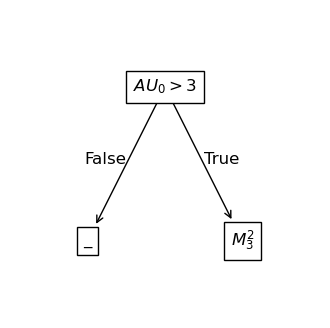

In [76]:
def plot_layer(idt_test, print_layer, leaves, labels={}, n=3):
    from sklearn.tree import plot_tree
    from sklearn import tree
    from sklearn.tree import DecisionTreeClassifier
    import matplotlib.pyplot as plt
    import matplotlib
    import re
    import numpy as np

    n_nodes = idt_test.layer[print_layer].dt.tree_.node_count
    children_left = idt_test.layer[print_layer].dt.tree_.children_left
    children_right = idt_test.layer[print_layer].dt.tree_.children_right
    feature = idt_test.layer[print_layer].dt.tree_.feature
    threshold = idt_test.layer[print_layer].dt.tree_.threshold
    values = idt_test.layer[print_layer].dt.tree_.value

    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    i=0
    for node in range(n_nodes):
        if i in leaves:
           is_leaves[i] = True
        i += 1
    print(is_leaves)
    fig, ax = plt.subplots(figsize=(4,4))
    plot_tree(idt_test.layer[print_layer].dt, ax=ax)
    leaf_counter = 2
    for obj in ax.properties()['children']:
        if type(obj) != matplotlib.spines.Spine \
        and type(obj) != matplotlib.axis.XAxis \
        and type(obj) != matplotlib.axis.YAxis \
        and type(obj) != matplotlib.patches.Rectangle:
            obj.set_fontsize(12)

        if type(obj) == matplotlib.text.Annotation:
            txt = obj.get_text().splitlines()[0]
            match = re.match(r'x\[(\d+)\] <= (\d+\.\d+)', txt)
            skip = False
            if match:
                feature, threshold = match.groups()
                feature = int(feature)
                formula = _feature_formula_TEST(feature, idt_test.layer[print_layer].depth_indices)
                threshold = float(threshold)
                if feature < idt_test.layer[print_layer].n_features_in:
                    obj.set_text(fr'$I{formula} > 0$')
                elif feature < 2 * idt_test.layer[print_layer].n_features_in:
                    obj.set_text(fr'$A{formula} > {int(threshold)}$')
                elif feature < 3 * idt_test.layer[print_layer].n_features_in:
                    obj.set_text(fr'$A^T{formula} > {int(threshold)}$')
                elif feature < 4 * idt_test.layer[print_layer].n_features_in:
                    obj.set_text(fr'$A{formula} > {threshold}$')
                elif feature < 5 * idt_test.layer[print_layer].n_features_in:
                    obj.set_text(fr'$A^T{formula} > {threshold}$')
            else:
                #print(is_leaves)
                #print(labels)
                if is_leaves[leaf_counter]:
                    print("LEAF :: " + str(leaf_counter))
                    obj.set_text(labels[leaf_counter])
                else:
                    labs = ["1", "2", "_", "False", "5", "True", "7"]
                    print("NOT :: " + str(leaf_counter))
                    #obj.set_text(str(leaf_counter))
                    obj.set_text(labs[leaf_counter])
                #if type(obj) == matplotlib.spines.Spine:
                #    print("SPINE :: " + str(leaf_counter))
                #    obj.set_text(r'''Spine''')
                leaf_counter += 1
    plt.show()
    plt.close()



layer_to_print = 2
leaf_list      = [1,4]
label_dic     = {1:r'''_''', 4:r'''$M_3^2$'''}

plot_layer(idt_test, print_layer=2, leaves=leaf_list, labels=label_dic)

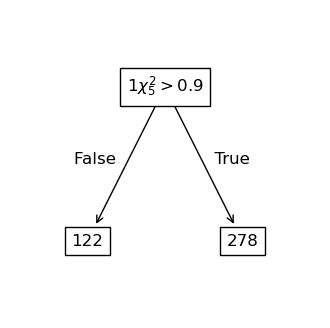

In [84]:
import matplotlib.pyplot as plt
from idt.idt import IDTFinalLayer, replace_text

fig, ax = plt.subplots(figsize=(4, 4))

idt_test.out_layer.plot(ax, len(idt_test.layer))
ax.properties()['children'] = [replace_text(i) for i in ax.properties()['children']]
plt.show()
plt.close()